# **WINES OF THE WORLD**

I was talking to a coworker recently and they casually mentioned how the quarantine life (if you are reading this sometime in the future, yes, I mean the iconic 2020) has made them appreciate good wine more than before. When asked why, they elaborated that previously wine was to be enjoyed with others, you would sit down with an older firend or family, or in a cafe overlooking a busy side walk and sip your wine - and the context would elevate ANY wine really - while now you can only count on Neflix show characters for company, whom are not always really wine people, you know... 
Well, that conversation more interested in digging deeper into the world of wine, and brought me to this data set here! I am going to use my basic knowledge to draw some intersting diagrams to share with the said friend, and also try my luck in creating a recommendation system based on the reviews that each wine has gotten.

Let's do this, shall we?


In [28]:
#importing libraries

import numpy as np 
import folium
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
from collections import Counter
import ast

import os

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [29]:
!pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.11.0)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [30]:
wine_df = pd.read_csv('/kaggle/input/wine-reviews/winemag-data-130k-v2.csv', index_col=0)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks





# **1 - Nulls**


First things first, let's take a look at Nulls and missing data in different columns. I noticed a couple of NaNs in the data frame sample above, so I would like to see a diagram of percentage of missing data in each column.




As the figure shows, around 60% of our data miss info in the region_2 column - since all the data has the country and province information, and more than 80% of the data has some info for the wine region, we can safely drop that column. We can then replace the Nulls in region_1 column with an empy string, to avoid any errors when mapping the data with that information.

Then it's notable that around 7% of the data is missing the price tag, which is quite an important feature for wine selection. So I am going to drop rows that miss the price point. We will come back to analyzing the price column again.

Also - in the data frame we have both the name of the taster (commentor) and their twitter handle - but since the twitter handle is not adding any depth to the data, and the missing info in that is higher than missing info in tatser name column, we can also drop that one as well.


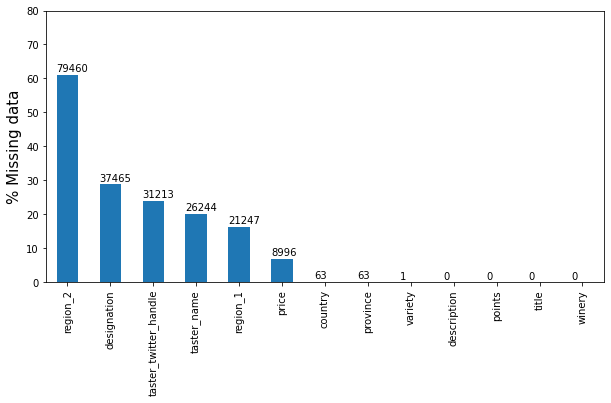

In [31]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_ylabel("% Missing data", fontsize = 15)

nullobj = (wine_df.isnull().sum().to_frame() / len(wine_df) * 100).sort_values(by = 0, ascending = False)
nullobj.plot(kind = 'bar', ax= ax, legend = False, ylim = (0, 80))

for p in ax.patches:
    ax.annotate(str(int(p.get_height() * len(wine_df) // 100)), (p.get_x(), p.get_height() + 1))

Now let's make the suggested changes and draw the figure again, to see if removing the rows that were missing the price data has had any significant effects on the missing data percentages in the rest of the columns.

In [32]:
wine_df = wine_df.drop( ['region_2', 'taster_twitter_handle'], axis = 1)

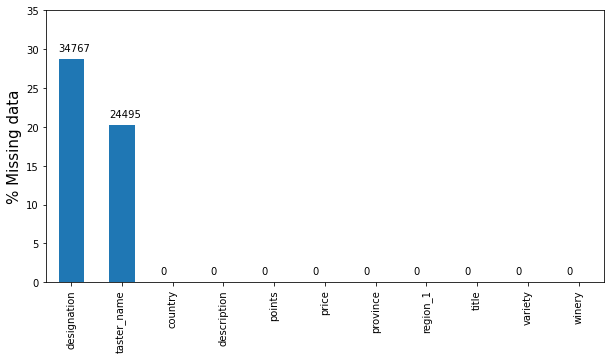

In [33]:
wine_df['region_1'].fillna(value = ' ' , inplace = True )
wine_df = wine_df.dropna( axis = 0, subset = ['price', 'country', 'province', 'variety'])

fig, ax = plt.subplots(figsize = (10, 5))
ax.set_ylabel("% Missing data", fontsize = 15)

nullobj = (wine_df.isnull().sum().to_frame() / len(wine_df) * 100).sort_values(by = 0, ascending = False)
nullobj.plot(kind = 'bar', ax= ax, legend = False, ylim = (0, 35))

for p in ax.patches:
    ax.annotate(str(int(p.get_height() * len(wine_df) // 100)), (p.get_x(), p.get_height() + 1))

The difference is negligible, but the visual representation helps to remind what columns might need extra attention as we go by.
Now since there is about 30% missing data in the column called 'designation', let's take a closer look at it's values and the counts of each, to understand it better. I am going to print the 25 most repeated values in that column:

In [34]:
wine_df['designation'].value_counts().to_frame().head(25)

,designation
Reserve,1977
Estate,1317
Reserva,1219
Estate Grown,618
Riserva,607
Brut,472
Dry,405
Estate Bottled,342
Crianza,338
Vieilles Vignes,272


To my surprise, the values in this column are not quite useful. As an starter, there are multiple values that should have probably been expressed in the same text, for exaple: *Reserve, Reserva, Gran Reserva, Réserve* - or *Rosé of* and *Rosé*. Hence I am not going to use the data in this column for now, unless I find a way to simplify the data in that column.

Next, let's look at the two numerical values assigned to the wines, points and prices, and add a column 'bang for the buck', as a ratio between the two.

In [35]:
wine_df = wine_df.drop( ['designation'], axis = 1)

In [36]:
wine_df['bang_for_buck'] =  round(wine_df['points'] / wine_df['price'], 2)
wine_df.describe()

,points,price,bang_for_buck
count,120915.000000,120915.000000,120915.000000
mean,88.421726,35.368796,3.840408
std,3.044954,41.031188,2.216757
min,80.000000,4.000000,0.030000
25%,86.000000,17.000000,2.120000
50%,88.000000,25.000000,3.440000
75%,91.000000,42.000000,5.120000
max,100.000000,3300.000000,21.500000


A quick look at the summary of the numerical values reveals that while the points come with an std of 3, and the mean is vey close to the 50% mark, the prices come in a much wider range, with a standard deviation of 41 and a max of 3300. It would make sense to take a closer look at the prices and take out any outliers that might skew any further invesigation.

First let's look at a histogram of the prices - but since we alreay know that 75% of the wines are below $42, we can skew the diagram to only show the bins larger than 100, and stop the diagram at 500 dollars.

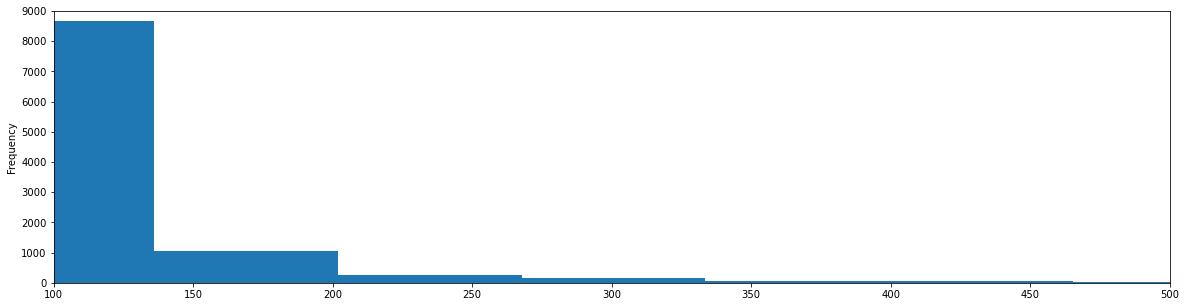

In [37]:
wine_df['price'].plot(kind = 'hist', bins = 50, xlim = (100, 500),ylim = (0,9000), figsize = (20, 5))

The figure above shows that the number of wines above the $200 range are quite limited, but to see the distribution better, we can take a look at the log of prices and their distribution, and a cumulative diagram of frequency of each price point.

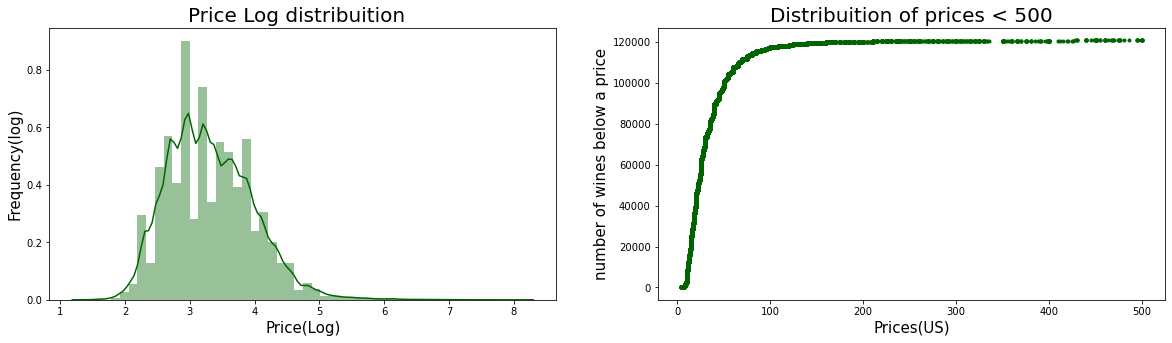

In [38]:
plt.figure(figsize=(20,5))

g1 = plt.subplot(1, 2, 1)
g1 = sns.distplot(np.log(wine_df['price']),color='darkgreen')
g1.set_title("Price Log distribuition  ", fontsize=20)
g1.set_xlabel("Price(Log)", fontsize=15)
g1.set_ylabel("Frequency(log)", fontsize=15)

plt.subplot(1, 2, 2)
plt.scatter(np.sort(wine_df.price.values)[:-100], range(wine_df.shape[0] - 100) , color='darkgreen', marker = '.')
plt.ylabel('number of wines below a price', fontsize=15)
plt.xlabel('Prices(US)', fontsize=15)
plt.title("Distribuition of prices < 500", fontsize=20)


plt.show()

Plot on the left shows that the price log distribution is not too far from the normal distribution, and the plot on the right shows that at some point between the prices of 100 and 200, the curves flattens which means there are not too many more data points after that. I think we can safely drop the wines with prices above 150, or alternatively change all those prices to 200 to represent the 'pricy' bucket.
For now I will remove them.

In [39]:
wine_df = wine_df[wine_df['price'] < 150]

Text(0, 0.5, 'frequency')

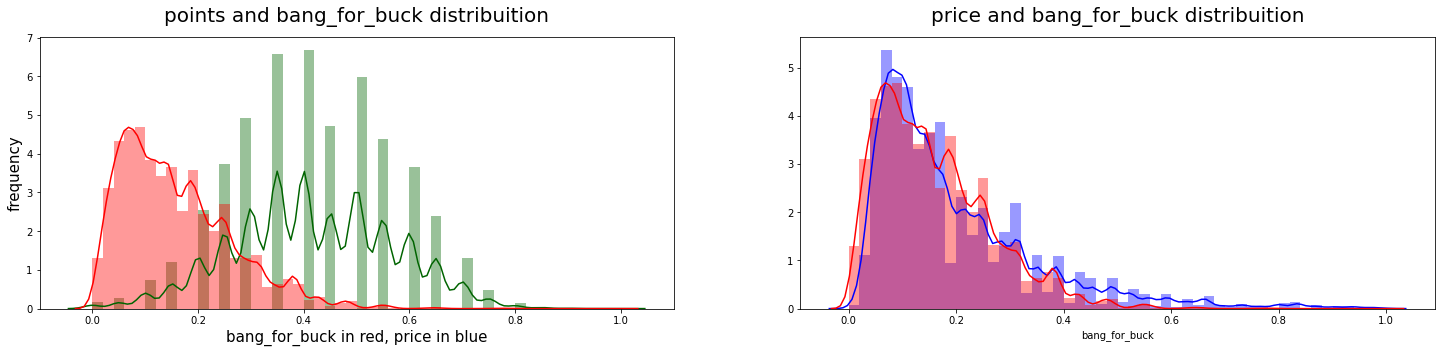

In [40]:
scaler = MinMaxScaler()
scaled = wine_df[['bang_for_buck', 'price', 'points']]

scaled = scaler.fit_transform(scaled)
scaled = pd.DataFrame({'bang_for_buck': scaled[:, 0], 'price': scaled[:, 1], 'points': scaled[:, 2]})

plt.figure(figsize=(25,5))

g1 = plt.subplot(1, 2, 1)
g1 = sns.distplot((scaled['points']),color='darkgreen')
g1 = sns.distplot((scaled['bang_for_buck']),color='red')
g1.set_title("points and bang_for_buck distribuition", fontsize=20, pad = 15)
g1.set_xlabel("bang_for_buck in red, points in green", fontsize=15)
g1.set_ylabel("frequency", fontsize=15)

g2 = plt.subplot(1, 2, 2)
g2 = sns.distplot((scaled['price']),color='blue')
g2 = sns.distplot((scaled['bang_for_buck']),color='red')
g2.set_title("price and bang_for_buck distribuition", fontsize=20, pad = 15)
g1.set_xlabel("bang_for_buck in red, price in blue", fontsize=15)
g1.set_ylabel("frequency", fontsize=15)



It is quite interesting that the two data points, 'price' and 'points per dollar' line up so closely on each other, while the distribution of the points is quite different from both items. To convert the data points to more useful items, we can bin the 'bang_for_buck' column into a few bands to see if we can use at as some sort of a ranking system between the wines. There is no right or wrong anser for the number of the bins, but I will be testing numbers between 4 to 10 to see which one has a more compelling look on it.

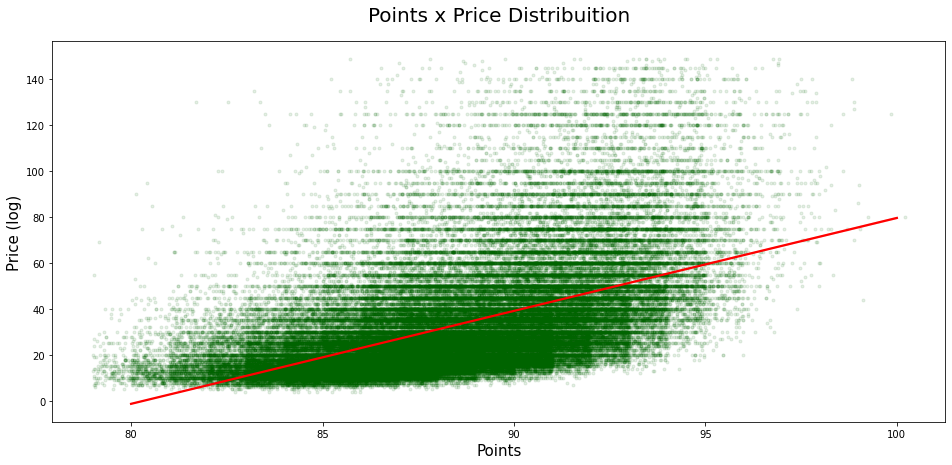

In [41]:
plt.figure(figsize=(16,7))

g = sns.regplot(x='points', y='price', data=wine_df , line_kws={'color':'red'}, marker = '.', x_jitter=True, fit_reg=True, color='darkgreen', scatter_kws={'alpha':0.1})
g.set_title("Points x Price Distribuition", fontsize=20, pad = 20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

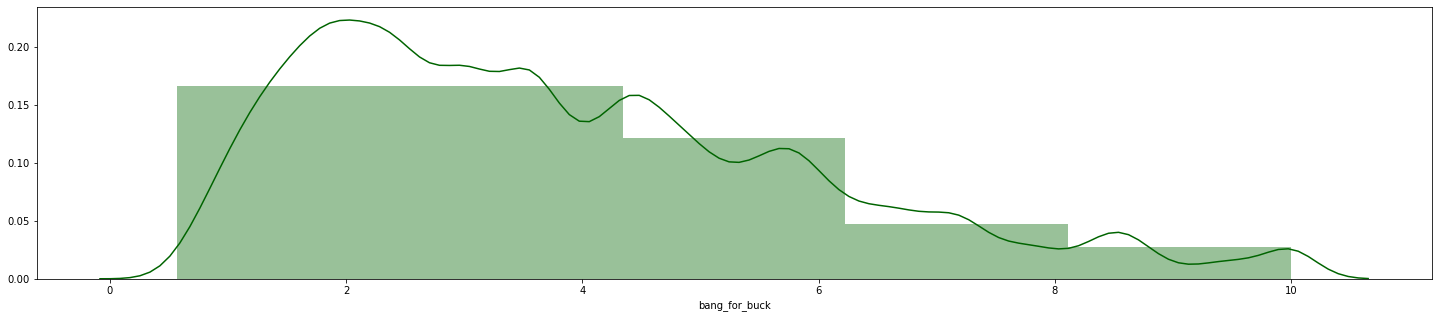

In [42]:
bb_bins = 5

plt.figure(figsize=(25,5))
wine_df['bang_for_buck'] = wine_df['bang_for_buck'].apply(lambda x: min(x, 10))
g1 = sns.distplot((wine_df['bang_for_buck']),color='darkgreen', bins = bb_bins)

In [43]:
wine_df['bang_for_buck_bin'] = 0
wine_df['bang_for_buck_bin'] = pd.cut(wine_df['bang_for_buck'], bins = bb_bins, labels = range(bb_bins))

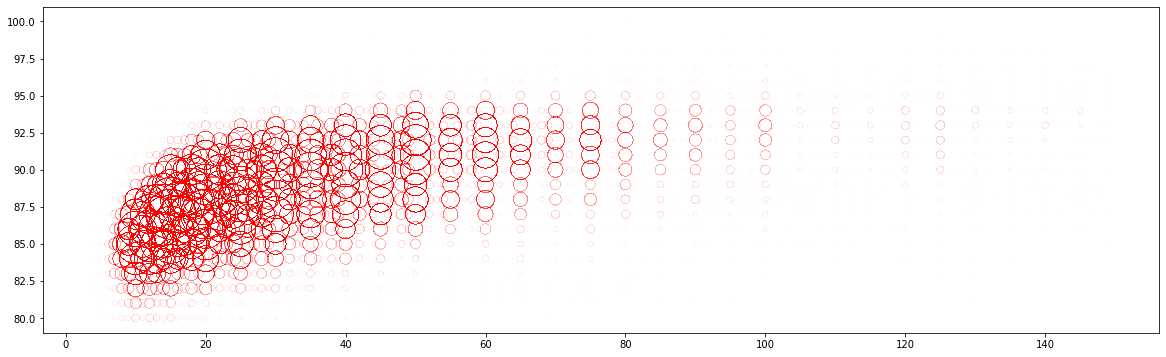

In [44]:
combos = list(zip(wine_df['price'],wine_df['points']))
weight_counter = Counter(combos)
weights = [weight_counter[(wine_df.iloc[i]['price'], wine_df.iloc[i]['points'])] for i in range(len(wine_df))]

#cdict = {0: 'mistyrose', 1:'lightpink'  , 2: 'salmon', 3: 'lightcoral', 4: 'brown', 5: 'blue'}


weights_2 = [item ** 1.1 for item in weights]
plt.figure(figsize=(20,6))
plt.scatter(wine_df['price'], wine_df['points'], s = weights_2, facecolors='none', edgecolors= 'red', alpha = 0.002 )
plt.show()

Here is a very interesting view of prices vs. points of our wines - the size and color of the circles above, show the frequency of a specific (price, point) pair in our set, and so far it looks like we have quite a density in our set for wines between 15 to 40 dollrs, with points ranging from 83 to 92.

I am going to try to draw the same diagram with sns since that might be easier to read:

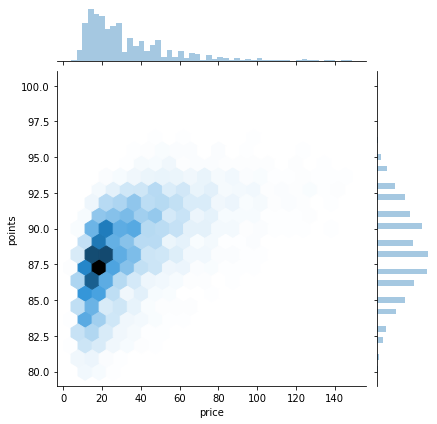

In [45]:
g = sns.jointplot(data = wine_df, x= 'price', y = 'points', kind="hex", joint_kws=dict(gridsize=20))

As I had imagined, the sns plot is in fact easier to read. As a wine enthusiast I find this quite fascinating, as it shows that with wines above 25 dollars, it is highly likely that you will get a wine with any score above 87.5, but with wines in the price range below that you are more likely to find a wine that would fall well below 90 points.






# wine varieties


time to take a look at types of wine in this data set! 
We will look at the number of each type in our set, their average price, average points, and try to understand the wines from that lense as well.

Text(0, 0.5, 'percentage of all wines')

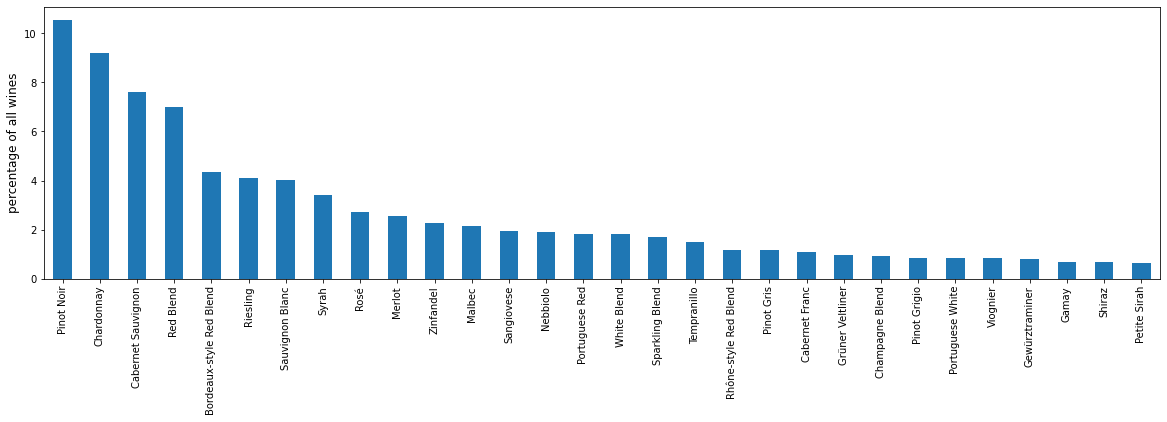

In [46]:
var_counts = (wine_df['variety'].value_counts()) / len(wine_df) * 100

fig, ax = plt.subplots(figsize=(20,5))
ax = var_counts.iloc[:30].plot(kind="bar")
ax.set_ylabel('percentage of all wines', fontsize=12)

In [47]:
var_counts.iloc[:30].sum()

81.1252040688183

# Location, location, location

Now that we have looked at points and prices, let's take a look at the origin of the wines. Here is a function that can look up latittude and longtitude numbers for any location - but since the data is larger than what my computer can take, I will be only using it on the top most expensive wines, and the top most appreciated wines (point wise)

In [48]:
from geopy.geocoders import Nominatim

def latlong(region):
    geoloc = Nominatim(user_agent="wine_app")
    loc = geoloc.geocode(region)
    if not loc:
        no_latlong.append(region)
        country = region.split(' ')
        loc = geoloc.geocode(country[0])
    if loc:
        return [round(2*loc.latitude) / 2, round(2*loc.longitude)/2]
    return 

In [49]:
wine_df['province'].replace(['Other'] ,' ', inplace = True)
wine_df['province'].replace(['Northern Spain'] ,' ', inplace = True)
wine_df['province'].replace(['Sicily & Sardinia'] ,'Sicily', inplace = True)
wine_df['province'].replace(['Northeastern Italy'] ,'Turin', inplace = True)
wine_df['province'].replace(['Vino de la Tierra de Castilla y León'] ,'Castilla y León', inplace = True)


In [50]:
wine_df['province'].value_counts()[:10]

California          35712
Washington           8574
Oregon               5349
Tuscany              4985
                     4258
Bordeaux             3886
Mendoza Province     3208
Piedmont             3009
Burgundy             2850
New York             2676
Name: province, dtype: int64

In [51]:
def californication(row):
    if (row['province'] in ['California', 'Washington', 'Oregon', ' ']) and len(row['region_1']) > 2 :
        return row['region_1']
    else:
        return row['province']

In [52]:
wine_df['province'] = wine_df.apply( lambda row: californication(row), axis = 1)
wine_df['address'] = wine_df.apply( lambda x : str(x['country']) + ' ' + str(x['province']), axis = 1)

In [60]:
#since the latlong conversion is quite time consuming, I made sure to save the produced dictionaries from that function, to read them later.

def jar_of_pickle(d, file):
    if d == 'write':
        with open('locatoin_dict_pickle', 'wb') as outfile:
            pickle.dump(file, outfile)
        return
    if d == 'read':
        with open('/kaggle/input/wine-latlong/location_dict_pickle', 'rb') as infile:
            file = pickle.load(infile)
        return file



In [62]:
#cell to be skipped as results have been saved and are ready to load. 
import pickle

# latlong_dict = {}
# latlong_reverse = {}
# no_latlong = []
# address_dict = {}

for i in tqdm(range(len(wine_df))) :    
    address = wine_df.iloc[i]['address']
    if (address) in latlong_dict.keys():
        pass
    else:
        if (address) in address_dict.keys():
            wine_df.loc[i, 'address'] = address_dict[address]
        else:
            new_latlong = str(latlong(address))
            if (new_latlong) in latlong_reverse.keys():
                wine_df.loc[i, 'address'] = latlong_reverse[new_latlong]
                address_dict[address] = latlong_reverse[new_latlong]
            else:
                latlong_dict[address] = new_latlong
                latlong_reverse[new_latlong] = address
                address_dict[address] = address

                
wine_df['address'] = wine_df['address'].map(address_dict)

100%|██████████| 119445/119445 [00:00<00:00, 1276534.27it/s]


In [ ]:
#new_dict = {'latlong_dict' : latlong_dict, 'latlong_reverse':latlong_reverse, 'address_dict':address_dict  }
new_dict = jar_of_pickle('read', new_dict)
latlong_dict, latlong_reverse, address_dict = new_dict['latlong_dict'], new_dict['latlong_reverse'], new_dict['address_dict']

In [ ]:
wine_df['count'] = 1
pivoted = pd.pivot_table(wine_df, index = 'address', values = ['count', 'price', 'points'], aggfunc = {'count':'sum', 'price':'mean', 'points':'mean'})

pivoted.reset_index(inplace = True)
pivoted['latlong'] = pivoted['address'].map(latlong_dict)

In [ ]:
scaler = StandardScaler()
pivoted[['price', 'points']] = scaler.fit_transform(pivoted[['price', 'points']].to_numpy())
pivoted['price']  = pivoted['price'].apply(lambda x : x + abs(pivoted['price'].min()))
pivoted['points']  = pivoted['points'].apply(lambda x : x + abs(pivoted['points'].min()))


In [ ]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[-0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = int(pivoted.iloc[i]['count']) * 100,
        color='red',
        fill=False,
        weight = 1,
   ).add_to(m)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Number of Wines from each region</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))

f.add_child(m)
f


In [ ]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = (int(pivoted.iloc[i]['price']) ** 3) * 4000 ,
        color='orange',
        fill=False,
        weight = 1,
   ).add_to(m)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Average price of wine from each region</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))
f.add_child(m)
f

In [ ]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = (int(pivoted.iloc[i]['points'])  ** 4) * 400 ,
        color='yellow',
        fill=False,
        weight = 1,
   ).add_to(m)

    title_html = '''
             <h3 align="center" style="font-size:20px"><b>Average points of wines from each region</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))
f.add_child(m)
f

In [ ]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = (int(pivoted.iloc[i]['points']) / (int(pivoted.iloc[i]['price']) + 0.1) ) ** 3.5  ,
        color='orange',
        fill=False,
        weight = 1,
   ).add_to(m)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>point to price ratio</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))
f.add_child(m)
f

In [ ]:
toploc = wine_df['address'].value_counts()[:20]

test = wine_df.groupby(['address', 'bang_for_buck_bin'])['address'].count().unstack('bang_for_buck_bin')
test = test.rename(columns=str).reset_index()

test = test.loc[test['address'].apply(lambda x: x in toploc)]
test = test.set_index('address').reindex(toploc.to_frame().index)

fig, ax = plt.subplots(figsize = (10, 5))
test.plot( kind = 'bar', stacked = True, ax = ax)

# Description and comments

It's time to get involved in the more complicated side of things... the comments! Let's first take a look at the length of comments and if it shows any relationship to the points.

In [ ]:
wine_df = wine_df.assign(desc_length = wine_df['description'].apply(len))

plt.figure(figsize=(12,7))
g = sns.boxplot(x='points', y='desc_length', data=wine_df, color='red', width = 0.5, fliersize = 0, whis = 0.5)
g.set_title('Description Length by Points', fontsize=20, pad = 20)
g.set_ylabel('Description Length', fontsize = 12)
g.set_xlabel('Points', fontsize = 12)
plt.show()

Fascinating. It's quite obvious that people have used so many more words to describe the wines that they liked, versus the ones that did not stand out to them.


Next, let's use python's wordcloud library to find the most repeated words in those texts.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=400,
    max_font_size=150, 
    width=2000, 
    height=1000,
    random_state=25,
).generate(" ".join(wine_df['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (20,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - FROM TASTER DESCRIPTION",fontsize=15, pad = 30)
plt.axis('off')
plt.show()

Now we can use the image above to fine tune the Stopwords. I will be adding anything and everything that does not do much to describe the wine quality, from big and ready to common english words that don't really provide much value here.

In [ ]:
newStopWords = ['wine', 'Drink', 'now', 'show', 'along', 'close', 'come', 'plenty', 
                'ready', 'make', 'big', 'will', 'seem', 'much', 'open', 'offer', 'add',
                'finish', 'offers', 'shows', 'little', 'way', 'need', 'start', 'year', 
                'right', 'best', 'first', 'needs', 'lot', 'take', 'bring', 'comes', 
                'quite', 'years', 'give', 'touch', 'made', 'end', 'opens', 'mouth',
                'brings', 'overall', 'notes', 'although', 'gives', 'find', 'though',
                'seems', 'produced', 'aren', 'couldn', 'didn', 'doesn', 'don', 'drink',
                'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 
                'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', 'drink', '2017', '2018']

stopwords.update(newStopWords)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=130, 
    width=2000, 
    height=1000,
    random_state=25,
).generate(" ".join(wine_df['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD UPDATED WORD STOP",fontsize=15, pad = 30)
plt.axis('off')
plt.show()

Much better. Everyword that I see in this image is a meaningful word to describe a quality in a wine, it's ingredients, the aroma, or the texture of it.

In [ ]:
# credit to https://www.kaggle.com/kabure, work in progress.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.gridspec as gridspec # to do the grid of plots

grid = gridspec.GridSpec(5, 2)
plt.figure(figsize=(16,7*4))

var = wine_df['variety'].value_counts()[:30]

for n, cat in enumerate(var.index[:10]):
    ax = plt.subplot(grid[n])   
    print(f'PRINCIPAL WORDS CATEGORY: {cat}')
    vectorizer = CountVectorizer(ngram_range = (3,3)) 
    vectorizer = TfidfVectorizer(ngram_range = (2, 3), min_df=5, stop_words= stopwords, max_df=.5) 
    
    X2 = vectorizer.fit_transform(wine_df.loc[(wine_df['variety'] == cat)]['description']) 
    #print(wine_df.iloc[(wine_df['address'])], cat)
    features = (vectorizer.get_feature_names()) 
    scores = (X2.toarray())
    
    sums = X2.sum(axis = 0) 
    data1 = [] 
    
    for col, term in enumerate(features): 
        data1.append( (term, sums[0,col] )) 

    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    words = (ranking.sort_values('rank', ascending = False))[:15]
    
    sns.barplot(x='term', y='rank', data=words, ax=ax, 
                color='blue', orient='v')
    ax.set_title(f"{cat} N-grams", fontsize=19)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel(' ')
    ax.set_xlabel(" ")

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.1)

plt.show()

My next step here would be to mark up a data frame with the words we found in the wordcloud, do some investigation and compare the ways to group the wines by, extract numbers representing those words for each category (by country? by winery? by variety?), then do a K-means on that data frame to find ways to cluster these wines together. 